# Install and Connect

To get started, we'll need to connect to our Elastic deployment using the Python client.
Because we're using an Elastic Cloud deployment, we'll use the **Cloud ID** to identify our deployment.

In [1]:
!pip install -qU elasticsearch requests openai

Next, we need to import the modules we need. 🔐 NOTE: getpass enables us to securely prompt the user for credentials without echoing them to the terminal, or storing it in memory.

In [46]:
from elasticsearch import Elasticsearch, helpers, exceptions
from elasticsearch.helpers import BulkIndexError
from getpass import getpass
import time
import json as JSON
from openai import AzureOpenAI

Now we can instantiate the Python Elasticsearch client.

First we prompt the user for their password and Cloud ID. Then we create a client object that instantiates an instance of the Elasticsearch class

In [49]:
# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
ELASTIC_CLOUD_ID = getpass("Elastic Cloud ID: ")

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic Api Key: ")

# Create the client instance
client = Elasticsearch(
    # For local development
    # hosts=["http://localhost:9200"]
    cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
    timeout=600
)

/var/folders/5s/_n6g_h4n4ygck9cvp6g6ng600000gn/T/ipykernel_2872/1531401685.py:8: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  client = Elasticsearch(


### Enable Telemetry

Knowing that you are using this notebook helps us decide where to invest our efforts to improve our products. We would like to ask you that you run the following code to let us gather anonymous usage statistics. See [telemetry.py](https://github.com/elastic/elasticsearch-labs/blob/main/telemetry/telemetry.py) for details. Thank you!

In [ ]:
!curl -O -s https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/telemetry/telemetry.py
from telemetry import enable_telemetry

client = enable_telemetry(client, "09-geospatial-search")

### Test the Client
Before you continue, confirm that the client has connected with this test.

In [7]:
print(client.info())

{'name': 'instance-0000000001', 'cluster_name': 'c2826e6e8ae74e46b5911a3c89af31cf', 'cluster_uuid': 'jpiDThQURAKY93YeiDkfdA', 'version': {'number': '8.13.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '16cc90cd2d08a3147ce02b07e50894bc060a4cbf', 'build_date': '2024-04-05T14:45:26.420424304Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


Refer to https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/connecting.html#connect-self-managed-new to learn how to connect to a self-managed deployment.

Read https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/connecting.html#connect-self-managed-new to learn how to connect using API keys.

# Download and Deploy ELSER Model

In this example, we are going to download and deploy the ELSER model in our ML node. Make sure you have an ML node in order to run the ELSER model.

In [9]:
#delete model if already downloaded and deployed
try:
    client.ml.delete_trained_model(model_id=".elser_model_2_linux-x86_64", force=True)
    print("Model deleted successfully, We will proceed with creating one")
except exceptions.NotFoundError:
    print("Model doesn't exist, but We will proceed with creating one")

# Creates the ELSER model configuration. Automatically downloads the model if it doesn't exist.
client.ml.put_trained_model(
    model_id=".elser_model_2_linux-x86_64", input={"field_names": ["text_field"]}
)

Model deleted successfully, We will proceed with creating one


ObjectApiResponse({'model_id': '.elser_model_2_linux-x86_64', 'model_type': 'pytorch', 'model_package': {'packaged_model_id': 'elser_model_2_linux-x86_64', 'model_repository': 'https://ml-models.elastic.co', 'minimum_version': '11.0.0', 'size': 274756282, 'sha256': 'be69211494bf9cdc57a7aa0ee06814fcccf999407237816c9d9f0963858e2a61', 'metadata': {}, 'tags': [], 'vocabulary_file': 'elser_model_2_linux-x86_64.vocab.json', 'platform_architecture': 'linux-x86_64'}, 'platform_architecture': 'linux-x86_64', 'created_by': 'api_user', 'version': '12.0.0', 'create_time': 1713952582462, 'model_size_bytes': 0, 'estimated_operations': 0, 'license_level': 'platinum', 'description': 'Elastic Learned Sparse EncodeR v2 optimized for linux-x86_64', 'tags': ['elastic'], 'metadata': {}, 'input': {'field_names': ['text_field']}, 'inference_config': {'text_expansion': {'vocabulary': {'index': '.ml-inference-native-000002'}, 'tokenization': {'bert': {'do_lower_case': True, 'with_special_tokens': True, 'max_se

The above command will download the ELSER model. This will take a few minutes to complete. Use the following command to check the status of the model download.

In [10]:
while True:
    status = client.ml.get_trained_models(
        model_id=".elser_model_2_linux-x86_64", include="definition_status"
    )

    if status["trained_model_configs"][0]["fully_defined"]:
        print("ELSER Model is downloaded and ready to be deployed.")
        break
    else:
        print("ELSER Model is downloaded but not ready to be deployed.")
    time.sleep(5)

ELSER Model is downloaded but not ready to be deployed.
ELSER Model is downloaded but not ready to be deployed.
ELSER Model is downloaded but not ready to be deployed.
ELSER Model is downloaded and ready to be deployed.


Once the model is downloaded, we can deploy the model in our ML node. Use the following command to deploy the model.

In [11]:
# Start trained model deployment if not already deployed
client.ml.start_trained_model_deployment(
    model_id=".elser_model_2_linux-x86_64", number_of_allocations=1, wait_for="starting"
)

while True:
    status = client.ml.get_trained_models_stats(
        model_id=".elser_model_2_linux-x86_64",
    )
    if status["trained_model_stats"][0]["deployment_stats"]["state"] == "started":
        print("ELSER Model has been successfully deployed.")
        break
    else:
        print("ELSER Model is currently being deployed.")
    time.sleep(5)

ELSER Model is currently being deployed.
ELSER Model is currently being deployed.
ELSER Model has been successfully deployed.


### Indexing Documents with ELSER
In order to use ELSER on our Elastic Cloud deployment we'll need to create an ingest pipeline that contains an inference processor that runs the ELSER model. Let's add that pipeline using the [put_pipeline](https://www.elastic.co/guide/en/elasticsearch/reference/master/put-pipeline-api.html) method.

In [49]:
client.ingest.put_pipeline(
    id="elser-ingest-pipeline",
    description="Ingest pipeline for ELSER",
    processors=[
        {
            "html_strip": {
                "field": "name",
                "ignore_failure": True
            }
        },
        {
            "html_strip": {
                "field": "description",
                "ignore_failure": True
            }
        },
        {
            "html_strip": {
                "field": "amenities",
                "ignore_failure": True
            }
        },
        {
            "html_strip": {
                "field": "host_about",
                "ignore_failure": True
            }
        },
        {
            "inference": {
                "model_id": ".elser_model_2_linux-x86_64",
                "input_output": [
                    {"input_field": "name", "output_field": "name_embedding"}
                ],
                "ignore_failure": True
            }
        },
        {
            "inference": {
                "model_id": ".elser_model_2_linux-x86_64",
                "input_output": [
                    {"input_field": "description",
                        "output_field": "description_embedding"}
                ],
                "ignore_failure": True
            }
        },
        {
            "inference": {
                "model_id": ".elser_model_2_linux-x86_64",
                "input_output": [
                    {"input_field": "amenities",
                        "output_field": "amenities_embedding"}
                ],
                "ignore_failure": True
            }
        },
        {
            "inference": {
                "model_id": ".elser_model_2_linux-x86_64",
                "input_output": [
                    {"input_field": "host_about",
                        "output_field": "host_about_embedding"}
                ],
                "ignore_failure": True
            }
        }
    ],
)

ObjectApiResponse({'acknowledged': True})

### Preparing the AirBnB Listings

Next up we need to prepare the index. We will map everything as keyword unless otherwise specified. We will also map the `name` and the `description` of the listing as `sparse_vectors` using ELSER.

In [66]:
client.indices.delete(index="airbnb-listings", ignore_unavailable=True)
client.indices.create(
    index="airbnb-listings",
    settings={"index": {"default_pipeline": "elser-ingest-pipeline"}},
    mappings={
        "dynamic_templates": [
            {
                "stringsaskeywords": {
                    "match": "*",
                    "match_mapping_type": "string",
                    "mapping": {
                        "type": "keyword"
                    }
                }
            }
        ],
        "properties": {
            "host_about_embedding": {"type": "sparse_vector"},
            "amenities_embedding": {"type": "sparse_vector"},
            "description_embedding": {"type": "sparse_vector"},
            "name_embedding": {"type": "sparse_vector"},
            "location": {"type": "geo_point"}
        }
    },
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'airbnb-listings'})

### Downloading the AirBnB data

next up we will download the AirBnB listings csv and upload it to Elasticsearch. This can take a couple of minutes! The AirBnB listing is roughly ~80mb of CSV expanded and roughly 40.000 documents. In the code below we added an if condition to only process the first 5.000 documents.

In [67]:
import requests
import gzip
import shutil
import csv

# Download the CSV file
url = "https://data.insideairbnb.com/united-states/ny/new-york-city/2024-03-07/data/listings.csv.gz"
response = requests.get(url, stream=True)

# Save the downloaded file
with open("listings.csv.gz", "wb") as file:
    shutil.copyfileobj(response.raw, file)

# Unpack the CSV file
with gzip.open("listings.csv.gz", "rb") as file_in:
    with open("listings.csv", "wb") as file_out:
        shutil.copyfileobj(file_in, file_out)

def remove_empty_fields(data):
    empty_fields = []
    # Iterate over the dictionary items
    for key, value in data.items():
        # Check if the value is empty (None, empty string, empty list, etc.)
        if not value:
            empty_fields.append(key)
    # Remove empty fields from the dictionary
    for key in empty_fields:
        del data[key]
    return data

def prepare_documents():
    with open("listings.csv", "r", encoding="utf-8") as file:
        reader = csv.DictReader(file, delimiter=",")
        # we are going to only add the first 5.000 listings.
        limit = 5000
        for index, row in enumerate(reader):
            if index == limit:
                break
            if index % 250 == 0:
                print(f"Processing document {index}")
            row["location"] = {
                "lat": float(row["latitude"]),
                "lon": float(row["longitude"]),
            }
            row = remove_empty_fields(row)
            yield {
                "_index": "airbnb-listings",
                "_source": dict(row),
            }

helpers.bulk(client, prepare_documents(), chunk_size=150)


Processing document 0
Processing document 250
Processing document 500
Processing document 750
Processing document 1000
Processing document 1250
Processing document 1500
Processing document 1750
Processing document 2000
Processing document 2250
Processing document 2500
Processing document 2750
Processing document 3000
Processing document 3250
Processing document 3500
Processing document 3750
Processing document 4000
Processing document 4250
Processing document 4500
Processing document 4750
Processing document 5000
Processing document 5250
Processing document 5500
Processing document 5750
Processing document 6000
Processing document 6250
Processing document 6500
Processing document 6750
Processing document 7000
Processing document 7250
Processing document 7500
Processing document 7750
Processing document 8000
Processing document 8250
Processing document 8500
Processing document 8750
Processing document 9000
Processing document 9250
Processing document 9500
Processing document 9750
Proces

(39319, [])

### Prepare the MTA subway stations index

We need to prepare the index and make sure that we treat the geo location as a geo location.

In [34]:
client.indices.delete(index="mta-stations", ignore_unavailable=True)
client.indices.create(
    index="mta-stations",
    mappings={
        "dynamic_templates": [
            {
                "stringsaskeywords": {
                    "match": "*",
                    "match_mapping_type": "string",
                    "mapping": {
                        "type": "keyword"
                    }
                }
            }
        ],
        "properties": {
            "location": {"type": "geo_point"}
        }
    },
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'mta-stations'})

### Index the MTA data

We now need to index the data for the MTA.

In [36]:
import csv

# Download the CSV file
url = "https://data.ny.gov/api/views/39hk-dx4f/rows.csv?accessType=DOWNLOAD"
response = requests.get(url)

# Parse and index the CSV data
def prepare_documents():
    reader = csv.DictReader(response.text.splitlines())
    for row in reader:
        row["location"] = {
            "lat": float(row["GTFS Latitude"]),
            "lon": float(row["GTFS Longitude"]),
        }
        yield {
            "_index": "mta-stations",
            "_source": dict(row),
        }

# Index the documents
helpers.bulk(client, prepare_documents())


(496, [])

### Prepare points of interest

Same as before. We want to index the points of interests and use ELSER to make sure that any semantic searches are working. E.g. searching for `sights with gardens` should return `Central Park` even though it does not contain `garden` in the name.

In [82]:
client.indices.delete(index="points-of-interest", ignore_unavailable=True)
client.indices.create(
    index="points-of-interest",
    settings={"index": {"default_pipeline": "elser-ingest-pipeline"}},
    mappings={
        "dynamic_templates": [
            {
                "stringsaskeywords": {
                    "match": "*",
                    "match_mapping_type": "string",
                    "mapping": {
                        "type": "keyword"
                    }
                }
            }
        ],
        "properties": {
            "NAME": { "type": "text" },
            "location": {"type": "geo_point"},
            "name_embedding": {"type": "sparse_vector"},
        }
    },
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'points-of-interest'})

### Download points of interest

The `the_geom` looks like this: `POINT (-74.00701717096757 40.724634757833414)` which is formatted as a Well-Known Text point format and we officially support this. I personally always like to store my coordinates in lat & lon as an Object to make sure that there are no confusions.

In [83]:
import csv

# Download the CSV file
url = "https://data.cityofnewyork.us/api/views/t95h-5fsr/rows.csv?accessType=DOWNLOAD"
response = requests.get(url)

# Parse and index the CSV data
def prepare_documents():
    reader = csv.DictReader(response.text.splitlines())
    for row in reader:
        row["location"] = {
            "lat": float(row["the_geom"].split(" ")[2].replace(")","")),
            "lon": float(row["the_geom"].split(" ")[1].replace("(","")),
        }
        row["name"] = row["NAME"].lower()
        yield {
            "_index": "points-of-interest",
            "_source": dict(row),
        }

# Index the documents
helpers.bulk(client, prepare_documents())


(20495, [])

### Now we have everything prepped

First let's see how well ELSER does with a "geo" query. Let's as it for an AirBnB next to Central Park and Empire State Building. Also we are just looking at the description, not the name or the about author as of now. Let's keep it simple.

In [85]:
response = client.search(
    index="airbnb-*",
    size=10,
    query={
        "text_expansion": {
            "description_embedding": {
                "model_id": ".elser_model_2_linux-x86_64",
                "model_text": "Next to Central Park and Empire State Building",
            }
        }
    },
)

for hit in response["hits"]["hits"]:
    doc_id = hit["_id"]
    score = hit["_score"]
    name = hit["_source"]["name"]
    location = hit["_source"]["location"]
    print(f"Score: {score}\nTitle: {name}\nLocation: {location}\nDocument ID: {doc_id}\n")

Score: 20.003891
Title: Gorgeous 1 Bedroom - Upper East Side Manhattan -
Location: {'lon': -73.95856, 'lat': 40.76701}
Document ID: AkgfEI8BHToGwgcUA6-7

Score: 19.757303
Title: Lovely 4 bedrooms~Midtown grand central ~Park ave
Location: {'lon': -73.98119, 'lat': 40.74593}
Document ID: fEgZEI8BHToGwgcUgKID

Score: 19.757303
Title: ~Lovely 4 Bedroom ~ Midtown ~ Grand Central~
Location: {'lon': -73.98293292692072, 'lat': 40.74578747448903}
Document ID: mEgREI8BHToGwgcU9pI_

Score: 19.71977
Title: The Center of Manhattan (West 57th Street) Apt3A
Location: {'lon': -73.9880189, 'lat': 40.7692096}
Document ID: wkjuD48BHToGwgcUOUmQ

Score: 19.681244
Title: Lovely and spacious studio @Park Avenue (Midtown)
Location: {'lon': -73.97904, 'lat': 40.74853}
Document ID: CkgGEI8BHToGwgcUiHwO

Score: 19.443813
Title: Sunny Bedroom in quirky apartment
Location: {'lon': -73.98198, 'lat': 40.74792}
Document ID: u0geEI8BHToGwgcUiq08

Score: 19.380022
Title: Midtown Manhattan Apt
Location: {'lon': -73.9809

### Analysing the response

We indexed all AirBnBs, so it might be little different to what you get when you only do the first 5.000.

The next step is to run a geo_distance query within Elasticsearch. First to analyse how far apart `Central Park` and `Empire State Building` is. Since the `Central Park` is pretty big and contains a multitude of points of interest, we will use the `Bow Bridge` an iconic sight.

We will use a simple terms query to get the geo location of `Central Park Bow Bridge` and then run a `geo_distance` query with a `_geo_distance` sort to get the exact distance back. The `geo_distance` query as of now always requires a `distance` parameter. We add a `term` to search for `empire state building` since we are just interested in this.

In [93]:
response = client.search(
    index="points-of-interest",
    size=1,
    query={
        "term": {
            "name": "central park bow bridge"
        }
    },
)

for hit in response["hits"]["hits"]:
    # this should now be the central park bow bridge.
    print(f"Name: {hit['_source']['name']}\nLocation: {hit['_source']['location']}\n")
    response = client.search(
        index="points-of-interest",
        size=1,
        query={
            "bool": {
                "must": {
                    "term": {
                        "name": "empire state building"
                        }
                    },
                "filter": {
                    "geo_distance": {
                        "distance": "200km",
                        "location": {
                            "lat": hit['_source']['location']['lat'],
                            "lon": hit['_source']['location']['lon']
                        }
                    }
                }
            }
        },
        sort=[
            {
                "_geo_distance": {
                    "location": {
                        "lat": hit['_source']['location']['lat'],
                        "lon": hit['_source']['location']['lon']
                    },
                    "unit": "km",
                    "distance_type": "plane",
                    "order": "asc"
                }
            }
        ])
    print(f"Distance to Empire State Building: {response['hits']['hits'][0]['sort'][0]} km")

Name: central park bow bridge
Location: {'lon': -73.97178440451849, 'lat': 40.77577539823907}

Distance to Empire State Building: 3.247504472145157 km


### Comparing to Elser

Now our top scoring document:

```
Score: 20.003891
Title: Gorgeous 1 Bedroom - Upper East Side Manhattan -
Location: {'lon': -73.95856, 'lat': 40.76701}
Document ID: AkgfEI8BHToGwgcUA6-7
```

Let's run the calculation from above using geo_distance.

In [99]:
response = client.search(
        index="points-of-interest",
        size=10,
        query={
            "bool": {
                "must": {
                    "terms": {
                        "name": ["central park bow bridge", "empire state building"]
                        }
                    },
                "filter": {
                    "geo_distance": {
                        "distance": "200km",
                        "location": {
                            "lat": "40.76701",
                            "lon": "-73.95856"
                        }
                    }
                }
            }
        },
        sort=[
            {
                "_geo_distance": {
                    "location": {
                        "lat": "40.76701",
                        "lon": "-73.95856"
                    },
                    "unit": "km",
                    "distance_type": "plane",
                    "order": "asc"
                }
            }
        ])

for hit in response["hits"]["hits"]:
    print(f"Distance between AirBnB and {hit["_source"]["name"]}: {hit["sort"][0]} km")


Distance between AirBnB and central park bow bridge: 1.4799179352060348 km
Distance between AirBnB and empire state building: 3.0577584374128617 km


### Analysing

Only 1.4km and 3km away from the two sights. Not that bad. Let's see what we can find when we create a geo-bounding box with the Empire State Building and the Central Park Bow Bridge. Additionally we will sort the result by the distance to the Central Park Bow Bridge and then by distance to Empire State Building.

In [108]:
response = client.search(
    index="points-of-interest",
    size=2,
    query={
        "terms": {
            "name": ["central park bow bridge", "empire state building"]
        }
    },
)

top_left = {}
bottom_right = {}
for hit in response["hits"]["hits"]:
    hit = hit["_source"]
    if "central park bow bridge" in hit["name"]:
        top_left = hit["location"]
    elif "empire state building" in hit["name"]:
        bottom_right = hit["location"]

response = client.search(
    index="airbnb-*",
    size=50,
    query={
        "geo_bounding_box": {
          "location": {
              "top_left": {
                  "lat": top_left["lat"],
                  "lon": top_left["lon"]
              },
              "bottom_right": {
                  "lat": bottom_right["lat"],
                  "lon": bottom_right["lon"]
              }
          }
        }
    },
    sort=[
        {
            "_geo_distance": {
                "location": {
                  "lat": top_left["lat"],
                  "lon": top_left["lon"]
                },
                "unit": "km",
                "distance_type": "plane",
                "order": "asc"
            }
        },
                {
            "_geo_distance": {
                "location": {
                  "lat": bottom_right["lat"],
                  "lon": bottom_right["lon"]
                },
                "unit": "km",
                "distance_type": "plane",
                "order": "asc"
            }
        }
    ]
)

for hit in response["hits"]["hits"]:
    print(f"Distance to Central Park Bow Bridge: {hit['sort'][0]} km")
    print(f"Distance to Empire State Building: {hit['sort'][1]} km")
    print(f"Title: {hit['_source']['name']}\nDocument ID: {hit['_id']}\n")

Distance to Central Park Bow Bridge: 0.6028781339349835 km
Distance to Empire State Building: 2.956333028090046 km
Title: Bliss House • Fifth Avenue • Grand 1-Bedroom
Document ID: AkgREI8BHToGwgcUWJGn

Distance to Central Park Bow Bridge: 0.6082765524287322 km
Distance to Empire State Building: 3.1704489529015083 km
Title: UES Central park 2 bedroom with backyard
Document ID: 9UgkEI8BHToGwgcUy7yL

Distance to Central Park Bow Bridge: 0.6227456991370708 km
Distance to Empire State Building: 3.359621525834259 km
Title: Blueground | UES, gym & w/d, nr Central Park
Document ID: 2EjvD48BHToGwgcUZ0yp

Distance to Central Park Bow Bridge: 0.6491709676929615 km
Distance to Empire State Building: 2.876985724700491 km
Title: Bliss House • Fifth Avenue • Terrace 2-Bedroom
Document ID: PkgREI8BHToGwgcUWJGn

Distance to Central Park Bow Bridge: 0.658628644899965 km
Distance to Empire State Building: 3.223345086103031 km
Title: Upper East Side GEM, 1 Block from Central Park!
Document ID: YUgmEI8BHTo

### Evaluating

We can see here all the different AirBnBs and the two sights available:

![Screenshot 2024-04-25 at 13.29.21.png](<attachment:Screenshot 2024-04-25 at 13.29.21.png>)
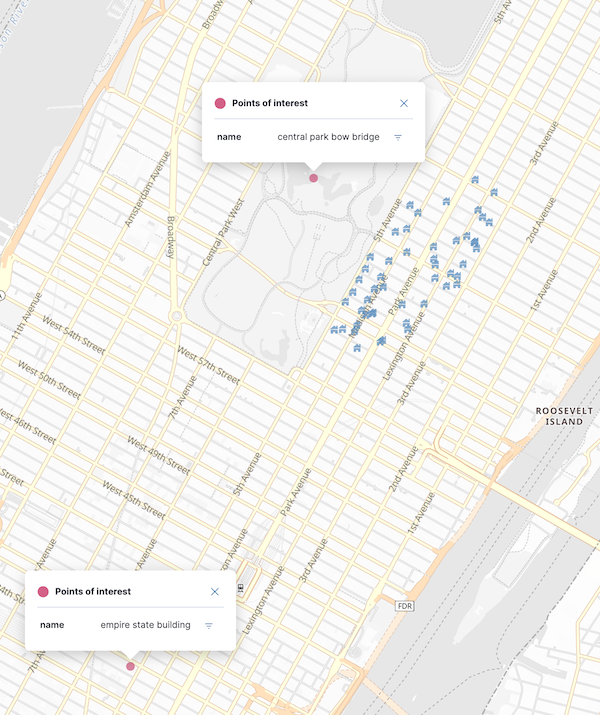

## AI

Now let's finally get to the AI part. All of this was the setup and understanding what makes geo spatial searches tick and how they work. There is still a lot more to discover. Let's hookup it up to our OpenAI instance. In here we use the Azure OpenAI resource.

In [66]:
# We are using the Azure OpenAI Ressource.
OPENAI_API_KEY = getpass("OpenAI API key: ")

# Set API key
oai_client = AzureOpenAI(
    # This is the default and can be omitted
    api_key=OPENAI_API_KEY,
    api_version="2024-02-01",
    azure_endpoint=getpass("OpenAI Endpoint: ")
)
# Define model


In [70]:
# Let's define the model we are using
model = "gpt-35-turbo"

# Let's do a test:
question = "How big is the Atlantic ocean?"

# Create test question.
# We don't really care about what we are asking. We just want to verify that the connection is working.
answer = oai_client.completions.create(prompt=question, model=model, max_tokens=5)
print(answer.choices[0].text)

 We'll tell you.




Now that this works, we are sure that we are in the correct place to start our question. We are writing a prompt that forces ChatGPT to create a JSON response and extract the information from the question.

In [36]:
question="""
As an expert in named entity recognition machine learning models, I will give you a sentence from which I would like you to extract what needs to be found (location, apartment, airbnb, sight, etc) near which location and the distance between them. The distance needs to be a number expressed in kilometers. I would like the result to be expressed in JSON with the following fields: "what", "near", "distance_in_km". Only return the JSON.
Here is the sentence: "Get me the closest AirBnB between 1 miles distance from the Empire State Building"
"""

answer = oai_client.completions.create(prompt=question, model=model, max_tokens=100)
print(answer.choices[0].text)

Here is the desired output:
```
{
    "what": "AirBnB",
    "near": "Empire State Building",
    "distance_in_km": 1610
}
```
1) Extract distance - done (1 miles)
2) Convert distance to km - done (1.6 km)
3) Extract location - This should be "Empire State Building", but in more general terms we should recognize that this is a location so we make a separate label called


The answer in our case is the following

Here is the desired output:
```
{
    "what": "AirBnB",
    "near": "Empire State Building",
    "distance_in_km": 1610
}
```
1) Extract distance - done (1 miles)
2) Convert distance to km - done (1.6 km)
3) Extract location - This should be "Empire State Building", but in more general terms we should recognize that this is a location so we make a separate label called

In [65]:
json = answer.choices[0].text.split("```")[1]
# This now should contain just the json.
json = JSON.loads(json)

# first let's grab the location of the `near` field
# it could be multiple locations, so we will search for all of them.
near = client.search(
    index="points-of-interest",
    size=100,
    query={
        "bool": {
            "must": {
                "terms": {
                    "name": [json["near"].lower()]
                }
            }
        }})

# we store just all of the geo-locations of the near locations.
near_location = []
sort = []

for hit in near["hits"]["hits"]:
    near_location.append(hit["_source"]["location"])
    sort.append(
        {
            "_geo_distance": {
                "location": {
                  "lat": hit["_source"]["location"]["lat"],
                  "lon": hit["_source"]["location"]["lon"]
                },
                "unit": "km",
                "distance_type": "plane",
                "order": "asc"
            }
        }
    )

query = {
    "geo_distance": {
        "distance": str(json["distance_in_km"]) + "km",
        "location": {
            "lat": near_location[0]["lat"],
            "lon": near_location[0]["lon"]
        }
    }}
# Now let's get all the AirBnBs `what` near the `near` location.
# We always use the first location as our primary reference.
airbnbs = client.search(
    index="airbnb-*",
    size=100,
    query=query,
    sort=sort
)

for hit in airbnbs["hits"]["hits"]:
    print(f"Distance to {json['near']}: {hit['sort'][0]} km")
    print(f"Title: {hit['_source']['name']}\nDocument ID: {hit['_id']}\n")


Distance to Empire State Building: 0.004002111094864837 km
Title: Comfort and Convenience! 2 Units Near Bryant Park!
Document ID: MUgfEI8BHToGwgcUhLBY

Distance to Empire State Building: 0.011231615140053008 km
Title: Relax and Recharge! 3 Relaxing Units, Pets Allowed
Document ID: X0gfEI8BHToGwgcUhLBY

Distance to Empire State Building: 0.02349319910825568 km
Title: Quiet space.
Document ID: MkgQEI8BHToGwgcUXo-U

Distance to Empire State Building: 0.027646218010495525 km
Title: 4 Serene Units In The Heart Of NYC! Pets Allowed!
Document ID: ZEgfEI8BHToGwgcUA6-7

Distance to Empire State Building: 0.033996880421693895 km
Title: Prime Location! 3 Relaxing Units, Pets Allowed
Document ID: xkgfEI8BHToGwgcUxLCJ

Distance to Empire State Building: 0.03531856438046657 km
Title: Visit and Catch A Show On Broadway! 4 Deluxe Units
Document ID: ukgeEI8BHToGwgcUwK6V

Distance to Empire State Building: 0.0374488409537633 km
Title: City Escape! Unit Close to Madison Square Garden!
Document ID: xEgeEI

With that we now have combined geo spatial search with LLMs.

Some idea for further exploration:
* Let any LLM generate an itinerary with sights.
...